In [41]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from interval import interval
from scipy.spatial import ConvexHull

In [42]:
def naive_bounds(X, y_lower, y_upper, x_grid=None):
    M = np.linalg.inv(X.T @ X) @ X.T  # shape (n_features, n_samples)
    y_intervals = [interval[y_l, y_u] for y_l, y_u in zip(y_lower, y_upper)]

    beta_naive = []
    for i in range(M.shape[0]):  # for each coefficient
        row = M[i]
        beta_j = interval[0, 0]
        for c, y_int in zip(row, y_intervals):
            beta_j += float(c) * y_int  # interval arithmetic
        beta_naive.append(beta_j)

    if x_grid is not None:
        beta0, beta1 = beta_naive
        y_min = []
        y_max = []
        for xg in x_grid:
            y_int = beta0 + beta1 * xg  # interval arithmetic
            y_min.append(y_int[0][0])
            y_max.append(y_int[0][1])
        return beta_naive, (np.array(y_min), np.array(y_max))
    
    return beta_naive



def actual_bounds(X, y_lower, y_upper, x_grid=None):
    M = np.linalg.inv(X.T @ X) @ X.T

    vertices = list(product(*zip(y_lower, y_upper)))
    beta_vertices = []
    for y_vertex in vertices:
        y_vertex = np.array(y_vertex)
        beta_vertex = M @ y_vertex
        beta_vertices.append(beta_vertex)

    if x_grid is not None:
        y_min, y_max = [], []
        for xg in x_grid:
            preds = [b[0] + b[1] * xg for b in beta_vertices]
            y_min.append(min(preds))
            y_max.append(max(preds))
        return beta_vertices, (np.array(y_min), np.array(y_max))
    
    return beta_vertices


Naive coefficient intervals: [interval([0.8142857142857128, 1.6190476190476188]), interval([0.4714285714285713, 0.7885714285714287])]
Actual coefficient samples: [array([1. , 0.6]), array([0.84761905, 0.71428571]), array([0.96666667, 0.66      ]), array([0.81428571, 0.77428571]), array([1.04761905, 0.61428571]), array([0.8952381 , 0.72857143]), array([1.01428571, 0.67428571]), array([0.86190476, 0.78857143]), array([1.11904762, 0.58571429]), array([0.96666667, 0.7       ]), array([1.08571429, 0.64571429]), array([0.93333333, 0.76      ]), array([1.16666667, 0.6       ]), array([1.01428571, 0.71428571]), array([1.13333333, 0.66      ]), array([0.98095238, 0.77428571]), array([1.19047619, 0.55714286]), array([1.03809524, 0.67142857]), array([1.15714286, 0.61714286]), array([1.0047619 , 0.73142857]), array([1.23809524, 0.57142857]), array([1.08571429, 0.68571429]), array([1.2047619 , 0.63142857]), array([1.05238095, 0.74571429]), array([1.30952381, 0.54285714]), array([1.15714286, 0.65714

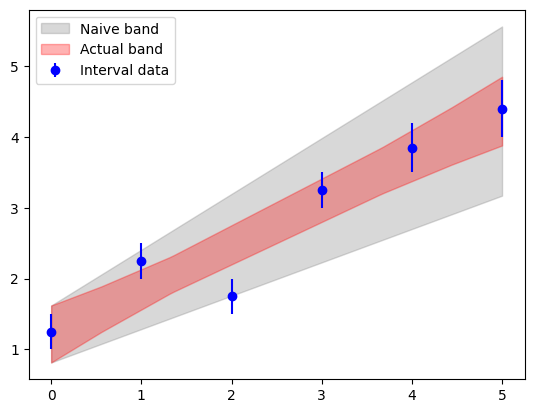

In [43]:
# --- Data ---
x = np.array([0, 1, 2, 3, 4, 5])
X = np.vstack([np.ones(len(x)), x]).T

y_lower = np.array([1.0, 2.0, 1.5, 3.0, 3.5, 4.0])
y_upper = np.array([1.5, 2.5, 2.0, 3.5, 4.2, 4.8])

x_grid = np.linspace(0, 5, 100)

# --- Run ---
beta_naive, (y_min_naive, y_max_naive) = naive_bounds(X, y_lower, y_upper, x_grid)
print("Naive coefficient intervals:", beta_naive)

beta_actual, (y_min, y_max) = actual_bounds(X, y_lower, y_upper, x_grid)
print("Actual coefficient samples:", beta_actual)

# --- Plot ---
plt.fill_between(x_grid, y_min_naive, y_max_naive, color='gray', alpha=0.3, label='Naive band')
plt.fill_between(x_grid, y_min, y_max, color='red', alpha=0.3, label='Actual band')
plt.errorbar(x, (y_lower+y_upper)/2, yerr=(y_upper-y_lower)/2, fmt='o', color='blue', label='Interval data')
plt.legend()
plt.show()

Naive coefficient intervals: [interval([1.6699994471070547, 3.833635810743424]), interval([0.23252970037874499, 0.6143478821969275])]
Actual coefficient intervals: [array([2.05181763, 0.42343879]), array([1.84818127, 0.49216606]), array([1.9245449 , 0.47689334]), array([1.72090854, 0.54562061]), array([2.00090854, 0.46162061]), array([1.79727217, 0.53034788]), array([1.87363581, 0.51507515]), array([1.66999945, 0.58380243]), array([2.07727217, 0.44634788]), array([1.87363581, 0.51507515]), array([1.94999945, 0.49980243]), array([1.74636308, 0.5685297 ]), array([2.02636308, 0.4845297 ]), array([1.82272672, 0.55325697]), array([1.89909036, 0.53798425]), array([1.69545399, 0.60671152]), array([2.15363581, 0.43107515]), array([1.94999945, 0.49980243]), array([2.02636308, 0.4845297 ]), array([1.82272672, 0.55325697]), array([2.10272672, 0.46925697]), array([1.89909036, 0.53798425]), array([1.97545399, 0.52271152]), array([1.77181763, 0.59143879]), array([2.17909036, 0.45398425]), array([1.9

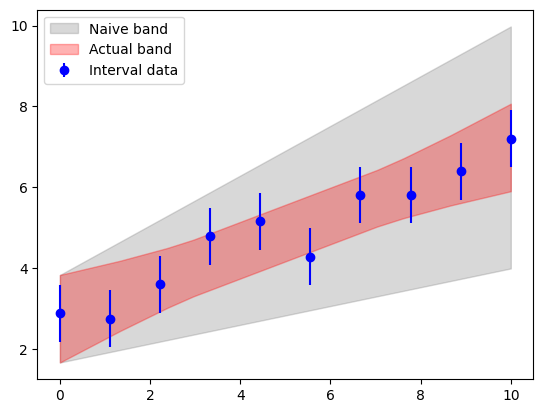

In [44]:
np.random.seed(0)

n = 10
x = np.linspace(0, 10, n)
X = np.vstack([np.ones(len(x)), x]).T

# "True" regression line
y_true = 2 + 0.5 * x  

# Add noise
noise = np.random.normal(0, 0.5, size=n)

# Create intervals: center ± width
y_obs = y_true + noise
interval_width = 0.7
y_lower = y_obs - interval_width
y_upper = y_obs + interval_width

# grid for plotting
x_grid = np.linspace(0, 10, 200)

beta_naive, (y_min_naive, y_max_naive) = naive_bounds(X, y_lower, y_upper, x_grid)

print("Naive coefficient intervals:", beta_naive)

beta_actual, (y_min, y_max) = actual_bounds(X, y_lower, y_upper, x_grid)

print("Actual coefficient intervals:", beta_actual)

plt.fill_between(x_grid, y_min_naive, y_max_naive, color='gray', alpha=0.3, label='Naive band')
plt.fill_between(x_grid, y_min, y_max, color='red', alpha=0.3, label='Actual band')
plt.errorbar(x, (y_lower+y_upper)/2, yerr=(y_upper-y_lower)/2, fmt='o', color='blue', label='Interval data')
plt.legend()
plt.show()


In [45]:
# unpack naive intervals
beta0_int, beta1_int = beta_naive
beta0_low, beta0_high = beta0_int[0][0], beta0_int[0][1]
beta1_low, beta1_high = beta1_int[0][0], beta1_int[0][1]

# collect actual betas as array
beta_actual = np.array(beta_actual)  # shape (#vertices, 2)

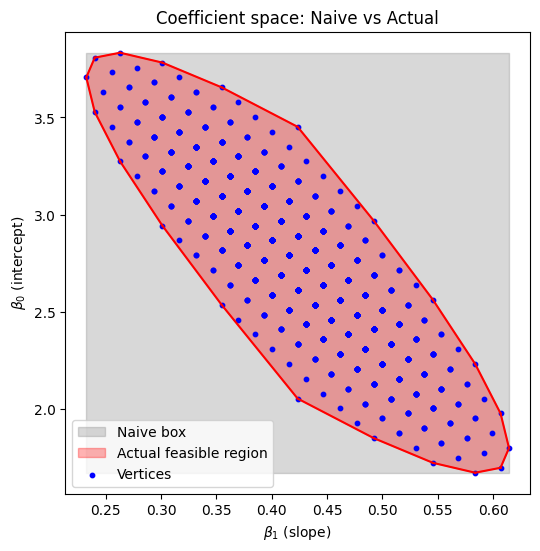

In [46]:
plt.figure(figsize=(6,6))

# naive box
plt.fill_between(
    [beta1_low, beta1_high], beta0_low, beta0_high,
    color="gray", alpha=0.3, label="Naive box"
)

# actual convex hull
hull = ConvexHull(beta_actual)
for simplex in hull.simplices:
    plt.plot(beta_actual[simplex,1], beta_actual[simplex,0], "r-")  # note: beta1 on x, beta0 on y

plt.fill(beta_actual[hull.vertices,1], beta_actual[hull.vertices,0], color="red", alpha=0.3, label="Actual feasible region")

# scatter actual betas
plt.scatter(beta_actual[:,1], beta_actual[:,0], color="blue", s=10, label="Vertices")

# labels
plt.xlabel(r"$\beta_1$ (slope)")
plt.ylabel(r"$\beta_0$ (intercept)")
plt.legend()
plt.title("Coefficient space: Naive vs Actual")
plt.show()